<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#User-Guide-on-nonlinear-example" data-toc-modified-id="User-Guide-on-nonlinear-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>User Guide on nonlinear example</a></span><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#DFS-with-fixed-hyper-parameters" data-toc-modified-id="DFS-with-fixed-hyper-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DFS with fixed hyper-parameters</a></span></li><li><span><a href="#Selection-of-$s$" data-toc-modified-id="Selection-of-$s$-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Selection of $s$</a></span></li></ul></li></ul></div>

# Deep Feature Selection
In this notebook, we will demonstrate how to implement our method on the nonlinear simulation examples from our paper.
## User Guide on nonlinear example
In this example, a high dimensional dataset with 500 covariates and 300 observations is generated using the following equation

\begin{equation}
    y=\begin{cases}
        1, & e^{x_1} + x_2^2 + 5\sin(x_3 x_4) - 3 > 0\\
        0, & \text{otherwise,}
    \end{cases}
\end{equation}

i.e. among 500 covariates, only the first 4 variables actually contributed to the response. Our task is to correctly select the important variables. Please see section 5.2 of the paper for detailed generation process.

In [1]:
import sys
sys.path.append("../../src")
from time import process_time
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import grad
from torch.nn.parameter import Parameter
from utils import data_load_n, data_load_l, measure, accuracy
from models import Net_nonlinear, Net_linear
from dfs import DFS_epoch, training_n

D:\Users\DELL\anaconda3\envs\bisheproject\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Preparation
We will load our data in the following chunk. The data, both covariates and response, need to be load as `pytorch` `Tensor` objects to be fed into the DFS algorithm. The function `data_load_n` will read in dataset and split it into training and test set so that both sets have same number of positive and negative samples.

In [2]:
# load and prepare datasets
dirc = "../../data/nonlinear/p_500_N_600_s_4/"
k = 0 # dataset number from 0 to 9
X, Y, X_test, Y_test = data_load_n(k, directory=dirc)
N, p = X.shape
print("The covariates is of type:", type(X))
print("The response is of type:", type(Y))
print()
print("The dimension of training set:", X.shape)
print("    The number of positive sample:", len(np.where(Y==1)[0]))
print("    The number of negative sample:", len(np.where(Y==0)[0]))
print()
print("The dimension of test set:", X.shape)
print("    The number of positive sample:", len(np.where(Y_test==1)[0]))
print("    The number of negative sample:", len(np.where(Y_test==0)[0]))

The covariates is of type: <class 'torch.Tensor'>
The response is of type: <class 'torch.Tensor'>

The dimension of training set: torch.Size([300, 500])
    The number of positive sample: 150
    The number of negative sample: 150

The dimension of test set: torch.Size([300, 500])
    The number of positive sample: 150
    The number of negative sample: 150


In [4]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, Y)

array([1.82296497e-02, 6.13420076e-03, 3.06890790e-02, 2.35162718e-02,
       3.18258766e-03, 1.56134466e-03, 5.52393791e-04, 3.33981761e-03,
       1.79582545e-03, 6.64251208e-04, 6.11024752e-04, 1.20297002e-03,
       5.33570618e-04, 5.42345170e-04, 2.23994350e-03, 2.13451602e-03,
       1.66030532e-03, 3.02105238e-03, 1.17502768e-03, 1.57717907e-03,
       4.54885918e-04, 8.96936824e-04, 3.79943982e-03, 2.34928342e-03,
       1.16274482e-03, 6.29979220e-04, 1.65182110e-03, 5.10396157e-04,
       1.82692864e-03, 4.01557324e-03, 6.90199755e-04, 2.21449237e-03,
       3.59864219e-03, 4.05390731e-04, 3.96843034e-04, 2.06057062e-03,
       3.74168327e-03, 4.62915538e-03, 4.59130330e-04, 1.41538739e-03,
       1.14544723e-03, 4.98970923e-04, 2.32210251e-04, 1.61983542e-03,
       1.00017781e-04, 8.30159792e-04, 1.31824608e-03, 2.32143509e-03,
       1.53823725e-03, 7.65030393e-04, 2.03507158e-03, 1.27992981e-03,
       2.76901346e-03, 9.67795031e-04, 1.72852594e-03, 2.90437208e-03,
      

In [6]:
pd.DataFrame(rf.feature_importances_).to_csv('RF_weight.csv')

In [5]:
pd.DataFrame(X).to_csv('X.csv',index=False)
pd.DataFrame(Y).to_csv('Y.csv',index=False)

In [3]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(500, 256) # 输入层到隐藏层
        self.fc2 = nn.Linear(256, 2)   # 隐藏层到输出层
        self.relu = nn.ReLU()          # 激活函数ReLU
        self.sigmoid = nn.Sigmoid()    # 激活函数Sigmoid

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

net = Net()
# 定义数据集
train_data = X # 100个样本，每个样本500维
train_labels = Y # 100个标签，0或1

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

# 训练网络
for epoch in range(9000):
    optimizer.zero_grad()   # 梯度清零
    outputs = net(train_data)  # 前向传播
    loss = criterion(outputs, train_labels)  # 计算损失
    loss.backward()  # 反向传播
    optimizer.step()  # 更新权重

    if (epoch+1) % 900 == 0:
        print('Epoch [%d/%d], Loss: %.4f'
              % (epoch+1, 10000, loss.item()))


Epoch [900/10000], Loss: 0.5913
Epoch [1800/10000], Loss: 0.4946
Epoch [2700/10000], Loss: 0.4159
Epoch [3600/10000], Loss: 0.3711
Epoch [4500/10000], Loss: 0.3476
Epoch [5400/10000], Loss: 0.3355
Epoch [6300/10000], Loss: 0.3290
Epoch [7200/10000], Loss: 0.3253
Epoch [8100/10000], Loss: 0.3228
Epoch [9000/10000], Loss: 0.3211


In [18]:
num_correct = 0
num_total = 0
outputs = net(X_test)
_,predicted = torch.max(outputs.data, 1)
num_total += Y_test.size(0)
num_correct += (predicted == Y_test).sum().item()
accuracy = num_correct / num_total
accuracy

0.74

In [5]:
num_correct = 0
num_total = 0
outputs = net(X)
_,predicted = torch.max(outputs.data, 1)
num_total += Y.size(0)
num_correct += (predicted == Y).sum().item()
accuracy = num_correct / num_total

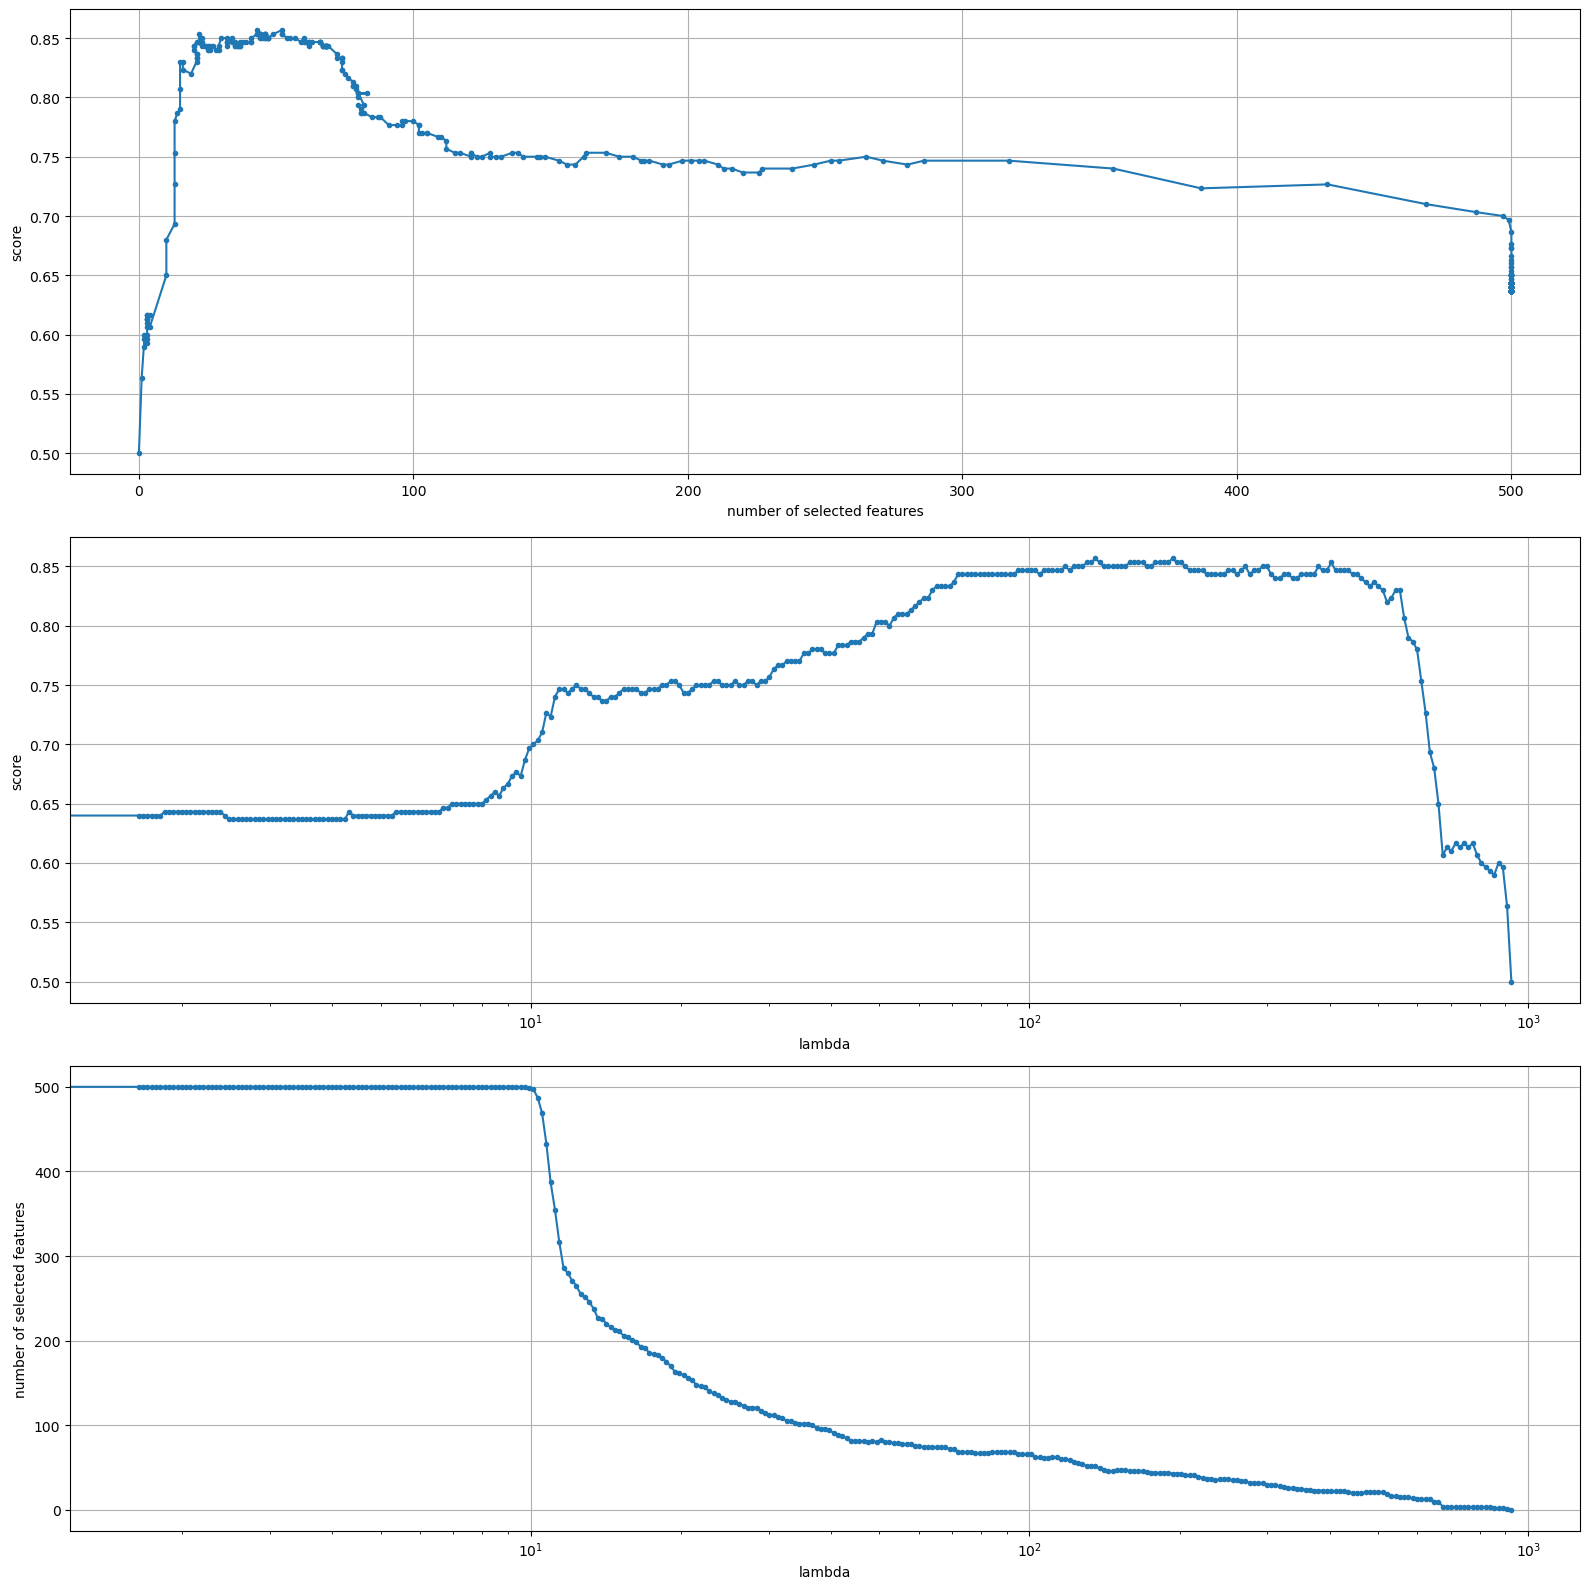

In [10]:
from lassonet import LassoNetClassifier, plot_path
model = LassoNetClassifier(hidden_dims=(50, 10))
path = model.path(X, Y)
plot_path(model, path, X_test, Y_test)

In [40]:
#问题是如何找到最优path 找到最小的val_loss即可 记录对应的path id
valloss= []
for p in path:
    valloss.append(p.val_loss)
min_val_loss = min(valloss)
index = valloss.index(min_val_loss)
print(index)
print(path[index].val_loss)
print(path[index].lambda_)
print(np.sum(np.array(path[index].selected)==True))

208
0.31241685152053833
98.77692315560522
66


In [48]:

pd.DataFrame(path[index].state_dict['skip.weight'][0]).to_csv('LassoNet_weight.csv')


# n_selected = [csave.seleted.sum() for save in path]
# lambda_ = [save.lambda_ for save in path]

### DFS with fixed hyper-parameters
In this section, we demonstrate how to run DFS with one given set of hyper-parameters. The hyper-parameters includes:
* `s`, the number of variables to be selected;
* `c`, the tunning parameters to control the magnitude of $\lambda_1$ and $\lambda_2$;
* `epochs`, the number of DFS iterations to be run;
* `n_hidden1` & `n_hidden2`, the number of neurons in the fully connect neural networks;
* `learning_rate`, the learning rate for optimizer;
* `Ts` & `step`, the parameters to control the optimization on given support

Among the above hyper-parameters, `s` is the most important parameters, and the selection of $s$ will be demonstrated in next sections. `c` can be selection through a sequence of candidates that returns the smallest loss function. Others mostly are meant to help the convergence of the optimization steps.

In [4]:
# specify hyper-paramters
s = 4
c = 1
epochs = 10
n_hidden1 = 50
n_hidden2 = 10
learning_rate = 0.05
Ts = 25 # To avoid long time waiting, this parameter has been shorten
step = 5


# Define Model
torch.manual_seed(1) # set seed
# Define a model with pre-specified structure and hyper parameters
model = Net_nonlinear(n_feature=p, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=2)
# Define another model to save the current best model based on loss function value
# The purpose is to prevent divergence of the training due to large learning rate or other reason
best_model = Net_nonlinear(n_feature=p, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=2)


# Define optimizers for the optimization with given support
# optimizer to separately optimize the hidden layers and selection layers
# the selection layer will be optimized on given support only.
# the optimzation of hidden layers and selection layer will take turn in iterations
optimizer = torch.optim.Adam(list(model.parameters()), lr=learning_rate, weight_decay=0.0025*c)
optimizer0 = torch.optim.Adam(model.hidden0.parameters(), lr=learning_rate, weight_decay=0.0005*c)


# Define loss function
lf = torch.nn.CrossEntropyLoss()


# Allocated some objects to keep track of changes over iterations
hist = []
SUPP = []
LOSSES = []
supp_x = list(range(p)) # initial support
SUPP.append(supp_x)


### DFS algorithm
start = process_time()
for i in range(epochs):
    # One DFS epoch
    model, supp_x, LOSS = DFS_epoch(model, s, supp_x, X, Y, lf, optimizer0, optimizer, Ts, step)
    LOSSES = LOSSES + LOSS
    supp_x.sort()
    # Save current loss function value and support
    hist.append(lf(model(X), Y).data.numpy().tolist())
    SUPP.append(supp_x)
    # Prevent divergence of optimization over support, save the current best model
    if hist[-1] == min(hist):
        best_model.load_state_dict(model.state_dict())
        best_supp = supp_x
    # Early stop criteria
    if len(SUPP[-1]) == len(SUPP[-2]) and (SUPP[-1] == SUPP[-2]).all():
        break

end = process_time()
print("Training finished in" , len(SUPP)-1, "epochs, and took", end-start, "seconds")

Training finished in 2 epochs, and took 10.609375 seconds


In the following chunk, we will demonstrate the results from the DFS algorithm, in terms of selected support, training error and test error for __one step__ procedure.

In [5]:
### Metric calculation
err_train_1 = 1-accuracy(best_model, X, Y)
err_test_1 = 1-accuracy(best_model, X_test, Y_test)
print("The support selected is:", best_supp)
print("The index of non-zero coefficents on selection layer:", 
      np.where(best_model.hidden0.weight != 0)[0])
print("The training error is:", err_train_1)
print("The test error is:", err_test_1)

The support selected is: [0 1 2 3]
The index of non-zero coefficents on selection layer: [0 1 2 3]
The training error is: 0.00666666666666671
The test error is: 0.050000000000000044


In [9]:
pd.DataFrame(best_model.hidden0.weight.data).to_csv('DFS_weight.csv')

From the results above, we have successfully selected the right support, i.e. the first 4 variables. (Note in `python` starting index is 0)

In the following chunk, we will perform a two-step procedure to train the `best_model` on the given support.

Two-step procedure is used for two reasons, to get better predictive performance and to get better estimation of $bic$ which is important in selection of optimal $s$.

As we demonstrated on the above chunk, the selection layer of `best_model` has non-zero coefficients on given support. In the second step, we treat `best_model` as our initial model and update parameters only in hidden layer.

In [5]:
# Define optimizer only update parameters in hidden layer.
_optimizer = torch.optim.Adam(list(best_model.parameters())[1:], lr=0.01, weight_decay=0.0025)
# Training
for _ in range(100):
    out = best_model(X)
    loss = lf(out, Y)
    _optimizer.zero_grad()
    loss.backward()
    _optimizer.step()

### metric calculation
acc_train = accuracy(best_model, X, Y)
acc_test = accuracy(best_model, X_test, Y_test)
print("The training accuracy of two step is: ", acc_train*100, "%", sep="")
print("The test accuracy of two step is: ", acc_test*100, "%", sep="")

The training accuracy of two step is: 100.0%
The test accuracy of two step is: 96.0%


The result has shown that the predictive performance of our model is increased. 

All good results shown above is based on the correct given $s$. However, in reality, $s$ is unknown for most of the time. So the next thing would be finding the optimal $s$

### Selection of $s$
In this section, we demonstrate the procedure of selection of optimal $s$. We have wrapped up the training procedure above in a function `training_n`. For each given $s$, $bic$, defined as $-2 \cdot \log \hat{L} + s \cdot \log n$, of the model will be automatically calculated by `training_n`, also the trained model with the given $s$ will also be returned.

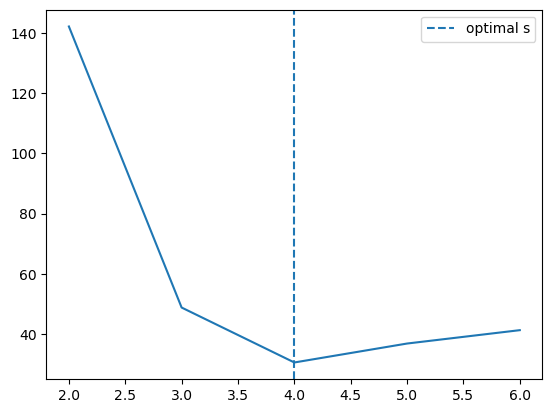

In [6]:
Ss = list(range(2, 7)) # We shorten the candidates list in the notebooks
BIC = [] # Store the bic for different s
best_model = Net_nonlinear(n_feature=p, n_hidden1=n_hidden1, n_hidden2=n_hidden2, n_output=2)
for i, s in enumerate(Ss):
    # Training dataset k with given s
    model, supp, bic, _, [err_train, err_test] = training_n(X, Y, X_test, Y_test, c, s, 
                                                            epochs=10, Ts=25)
    # Store bic values
    BIC.append(bic)
    # if current bic is the smallest, save the trained model, support and other metric
    if bic == min(BIC):
        best_model.load_state_dict(model.state_dict())
        best_supp = supp
        best_err_train, best_err_test = err_train, err_test # one step model training and testing error

idx = np.argmin(BIC)
best_s = Ss[idx]
plt.plot(Ss, BIC)
plt.axvline(x=best_s, ls='--', label="optimal s")
plt.legend()
plt.show()

From the graph above, we can tell $s=4$ is the optimal $s$, and the corresponding model is stored in `best_model` which is the same model showed in section 1.2